# Variational Image Domain Analysis

Imaging is one of the first steps in imaging. After you want to move from image domain to feature domain. By features, we mean image structures that are *interesting*. For example, in the analysis of M87 we were interested in the diameter, width, brightness position angle and asymmetry. 

VIDA is a generic tools specifically designed to work with the EHT and its images. In this notebook we will demonstrate how to use VIDA to extract quantitative image feature estimates from the image you just created.

In [1]:
# This creates a local environment in Julia so you can explore a number of things
using Pkg; Pkg.activate(@__DIR__)

  Activating new environment at `~/Research/Projects/ngEHT/Tutorial/Project.toml`


In [2]:
# Now lets add VIDA and a plotting routine
Pkg.add("VIDA")
Pkg.add("Plots")

    Updating registry at `~/.julia/registries/General`
   Resolving package versions...
   Installed Blosc ────────── v0.7.1
   Installed Compat ───────── v3.40.0
   Installed IfElse ───────── v0.1.1
   Installed VIDA ─────────── v0.10.7
   Installed PDMats ───────── v0.11.2
   Installed ArrayInterface ─ v3.1.38
    Updating `~/Research/Projects/ngEHT/Tutorial/Project.toml`
  [4096cdfb] + VIDA v0.10.7
    Updating `~/Research/Projects/ngEHT/Tutorial/Manifest.toml`
  [621f4979] + AbstractFFTs v1.0.1
  [79e6a3ab] + Adapt v3.3.1
  [4fba245c] + ArrayInterface v3.1.38
  [13072b0f] + AxisAlgorithms v1.0.1
  [a134a8b2] + BlackBoxOptim v0.6.0
  [a74b3585] + Blosc v0.7.1
  [3b1b4be9] + CFITSIO v1.4.0
  [8d3b24bd] + CMAEvolutionStrategy v0.2.2
  [a9c8d775] + CPUTime v1.0.0
  [aafaddc9] + CatIndices v0.2.2
  [d360d2e6] + ChainRulesCore v1.11.0
  [3da002f7] + ColorTypes v0.11.0
  [c3611d14] + ColorVectorSpace v0.9.7
  [5ae59095] + Colors v0.12.8
  [bbf7d656] + CommonSubexpressions v0.3.0
  [34da21

Precompiling project...
  ✓ IfElse
  ✓ Blosc
  ✓ PDMats
  ✓ Compat
  ✓ Static
  ✓ ArrayInterface
  ✓ ChainRulesCore
  ✓ HDF5
  ✓ DataStructures
  ✓ FiniteDiff
  ✓ SortingAlgorithms
  ✓ LogExpFunctions
  ✓ QuadGK
  ✓ Interpolations
  ✓ StatsBase
  ✓ SpecialFunctions
  ✓ DiffRules
  ✓ StatsFuns
  ✓ ColorVectorSpace
  ✓ ForwardDiff
  ✓ NLSolversBase
  ✓ Distributions
  ✓ LineSearches
  ✓ BlackBoxOptim
  ✓ Optim
  ✓ DataFrames
  ✓ ImageCore
  ✓ ImageFiltering
  ✓ VIDA
  29 dependencies successfully precompiled in 82 seconds (81 already precompiled)
   Resolving package versions...
   Installed GR_jll ─── v0.62.0+0
   Installed GLFW_jll ─ v3.3.5+1
   Installed Plots ──── v1.23.2
    Updating `~/Research/Projects/ngEHT/Tutorial/Project.toml`
  [91a5bcdd] + Plots v1.23.2
    Updating `~/Research/Projects/ngEHT/Tutorial/Manifest.toml`
  [35d6a980] + ColorSchemes v3.15.0
  [d38c429a] + Contour v0.5.7
  [c87230d0] + FFMPEG v0.4.1
  [28b8d3ca] + GR v0.61.0
  [5c1252a2] + GeometryBasics v0.4.1
  [

In [3]:
# Load the packages
using VIDA
using Plots

┌ Info: Precompiling VIDA [4096cdfb-f084-40a3-b02d-1a2a54920cb8]
└ @ Base loading.jl:1342
┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1342


## Loading the image and deciding on image features

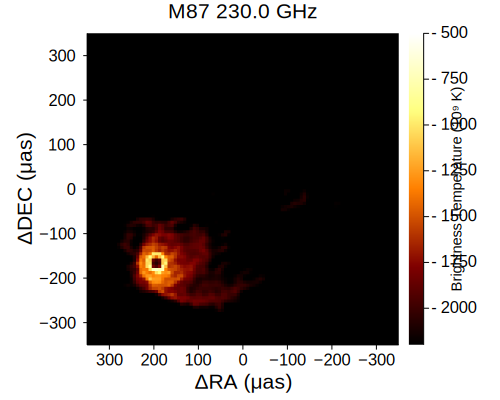

In [108]:
img = load_image("results/M87_ngeht_ref1_230_thnoise.fits")

#Make the image log-scale so we can see the jet base.
plot(log10.(img./flux(img)), clims=(-2200, -500))

## Deciding on a template

VIDA is basically a template matching algorithm. Which mean we need to decide on the specific image structure we want to extract. In this image there are two components

1. The ring
2. The jet or larger Gaussian structure

For 1 we will use the `SymCosineRing` template. To see its detail please see the docs or pull them up using Julia's help.

For 2 we will use the `AsymGaussian` template. This is a asymmetric Gaussian template. 

Finally we will include a `Constant` filter to deal with the low level diffuse flux the commonly appears in these image reconstructions

To stack templates, VIDA has overloaded the `+` operator to construct a composite model. To construct our template we do:

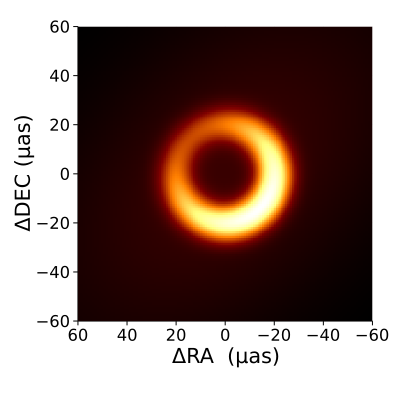

In [134]:
# The ring is rather simple so lets use a 0,2 cosine ring
template = SymCosineRing{0,2}(r0 = 20.0, #ring radius in μas
                              σ = [5.0], #ring width in μas
                              ξσ = [], # Empty because N=0 so no expansion in width
                              s = [0.5, 0.0], # brightness cosine expansion amplitdues
                              ξs = [-3π/4, 0.0], # brightness cosine expansion phases
                              x0 = 0.0, #ring center in RA
                              y0 = 0.0  #rin center in DEC
                             ) + 0.2*AsymGaussian(σ=50.0, τ=0.4, ξ=-π/4, x0=0.0, y0=0.0) + 0.1*Constant()
# Plots the appearance of the template
plot(template)

Now let's fit the template! To do this we need to define our boundaries. We will do this by specifying the upper and lower template

In [135]:
upper = SymCosineRing{0,2}(r0 = 60.0, #ring radius
                              σ = [40.0], #ring width
                              ξσ = [], # Empty because N=0 so no expansion in width
                              s = [0.99, 1.0], # brightness cosine expansion amplitdues
                              ξs = [1π, 1π], # brightness cosine expansion phases
                              x0 = 300.0,
                              y0 = 300.0
                             ) + 1.0*AsymGaussian(σ=500.0, τ=0.99, ξ=π/2, x0=400.0, y0=400.0) + 0.5*Constant()
lower = SymCosineRing{0,2}(r0 = 5.0, #ring radius
                              σ = [0.1], #ring width
                              ξσ = [], # Empty because N=0 so no expansion in width
                              s = [0.01, -1.0], # brightness cosine expansion amplitdues
                              ξs = [-π, -π], # brightness cosine expansion phases
                              x0 = -300.0,
                              y0 = -300.0
                             ) + 1e-6*AsymGaussian(σ=5.0, τ=0.01, ξ=-π/2, x0=-400.0, y0=-400.0) + 1e-8*Constant()

VIDA.AddTemplate{VIDA.AddTemplate{SymCosineRing{0, 2}, VIDA.MulTemplate{AsymGaussian, Float64}}, VIDA.MulTemplate{Constant, Float64}}(VIDA.AddTemplate{SymCosineRing{0, 2}, VIDA.MulTemplate{AsymGaussian, Float64}}(SymCosineRing{0, 2}
  r0: Float64 5.0
  σ: Array{Float64}((1,)) [0.1]
  ξσ: Array{Float64}((0,)) Float64[]
  s: Array{Float64}((2,)) [0.01, -1.0]
  ξs: Array{Float64}((2,)) [-3.141592653589793, -3.141592653589793]
  x0: Float64 -300.0
  y0: Float64 -300.0
, VIDA.MulTemplate{AsymGaussian,Float64}
θ: AsymGaussian
  σ: Float64 5.0
  τ: Float64 0.01
  ξ: Float64 -1.5707963267948966
  x0: Float64 -400.0
  y0: Float64 -400.0
Irel: Float64 1.0e-6
), VIDA.MulTemplate{Constant,Float64}
θ: Constant()Irel: Float64 1.0e-8
)

## Selecting the divergence

VIDA uses probability divergences as its cost function. There are a number of different divergences implemented. To see them we can use the `subtypes(VIDA.AbstractDivergence)` method

In [136]:
subtypes(VIDA.AbstractDivergence)

4-element Vector{Any}:
 Bhattacharyya
 KullbackLeibler
 LeastSquares
 Renyi

 For this problem we will use the Bhattacharyya divergence

In [137]:
bh = Bhattacharyya(img)

Bhattacharyya{EHTImage{Float64, Matrix{Float64}}, Float64}([5.8307343678454174e-8 7.048651867918633e-8 … 4.3387264098439613e-11 2.6057231904058662e-11; 7.051288705744571e-8 8.532831149853831e-8 … 7.050143081054508e-11 4.3308679728756146e-11; … ; 4.366545234888053e-11 7.084820022222649e-11 … 7.209641795655416e-11 4.424505920648843e-11; 2.61821017858045e-11 4.345771894914635e-11 … 4.42302739882524e-11 2.6546686553652826e-11], 0.7629558866636356)

In [141]:
# Now construct the optimization problem

prob = ExtractProblem(bh, template, lower, upper)

# Now find the minimum using the CMA optimizer
opt, divmin = extractor(prob, BBO())

Starting optimization with optimizer BlackBoxOptim.DiffEvoOpt{BlackBoxOptim.FitPopulation{Float64}, BlackBoxOptim.RadiusLimitedSelector, BlackBoxOptim.AdaptiveDiffEvoRandBin{3}, BlackBoxOptim.RandomBound{BlackBoxOptim.ContinuousRectSearchSpace}}
0.00 secs, 0 evals, 0 steps
0.50 secs, 522 evals, 420 steps, improv/step: 0.402 (last = 0.4024), fitness=0.408837052
1.00 secs, 1055 evals, 953 steps, improv/step: 0.345 (last = 0.3002), fitness=0.339573826
1.50 secs, 1585 evals, 1483 steps, improv/step: 0.308 (last = 0.2415), fitness=0.231875226
2.00 secs, 2121 evals, 2019 steps, improv/step: 0.280 (last = 0.2034), fitness=0.231672103
2.50 secs, 2665 evals, 2563 steps, improv/step: 0.258 (last = 0.1728), fitness=0.220967511
3.00 secs, 3201 evals, 3099 steps, improv/step: 0.248 (last = 0.2052), fitness=0.163437661
3.50 secs, 3743 evals, 3641 steps, improv/step: 0.236 (last = 0.1679), fitness=0.163437661
4.00 secs, 4283 evals, 4181 steps, improv/step: 0.227 (last = 0.1648), fitness=0.163437661
4

(VIDA.AddTemplate{VIDA.AddTemplate{SymCosineRing{0, 2}, VIDA.MulTemplate{AsymGaussian, Float64}}, VIDA.MulTemplate{Constant, Float64}}(VIDA.AddTemplate{SymCosineRing{0, 2}, VIDA.MulTemplate{AsymGaussian, Float64}}(SymCosineRing{0, 2}
  r0: Float64 18.285428205600954
  σ: Array{Float64}((1,)) [2.752816409328447]
  ξσ: Array{Float64}((0,)) Float64[]
  s: Array{Float64}((2,)) [0.5905830968647792, -0.25024367857465885]
  ξs: Array{Float64}((2,)) [-1.7147530012515355, 1.2062093816227288]
  x0: Float64 192.27457825872256
  y0: Float64 -162.6414913187262
, VIDA.MulTemplate{AsymGaussian,Float64}
θ: AsymGaussian
  σ: Float64 39.430862431795404
  τ: Float64 0.12231725821308807
  ξ: Float64 0.5807488035190597
  x0: Float64 177.01736334670863
  y0: Float64 -173.55292047500478
Irel: Float64 0.06548232578343291
), VIDA.MulTemplate{Constant,Float64}
θ: Constant()Irel: Float64 0.00046085017089156414
), 0.04903089392347514)

Now lets evaluate the results!

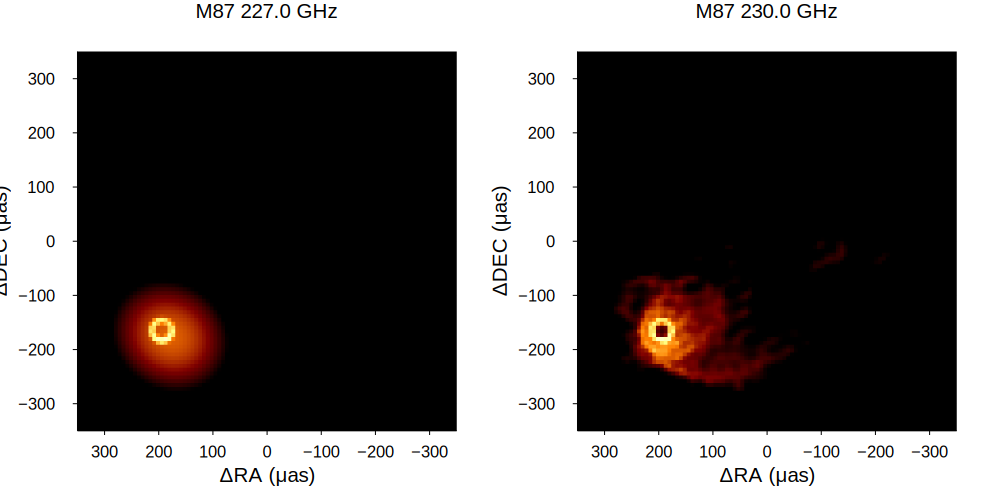

In [161]:
# Create an image object from the optimal template
optimg = VIDA.make_image(opt, 100, (-350, 350), (-350,350))

p1 = plot(log10.(optimg./flux(optimg)), clims=(-2250, -500), colorbar=:none)
p2 = plot(log10.(img./flux(img)), clims=(-2250, -500), colorbar=:none, ylabel="")
plot(p1, p2, layout=(1,2), size=(1000, 500))

Well from that is looks like we are doing a decent job! What are the ring parameters?

Now lets focus on the ring

In [171]:
p1 = plot(optimg./flux(optimg), colorbar=:none)
xlims!(p1, ropt.x0-2*ropt.r0, ropt.x0+2*ropt.r0)
ylims!(p1, ropt.y0-2*ropt.r0, ropt.y0+2*ropt.r0)

p2 = plot(img./flux(img), colorbar=:none)
xlims!(p2, ropt.x0-2*ropt.r0, ropt.x0+2*ropt.r0)
ylims!(p2, ropt.y0-2*ropt.r0, ropt.y0+2*ropt.r0)

plot(p1, p2, layout=(1,2), size=(1000, 500))


In [166]:
# SPlit the template object into components and extract the ring which is the first one
ropt = split(opt)[1]

SymCosineRing{0, 2}
  r0: Float64 18.285428205600954
  σ: Array{Float64}((1,)) [2.752816409328447]
  ξσ: Array{Float64}((0,)) Float64[]
  s: Array{Float64}((2,)) [0.5905830968647792, -0.25024367857465885]
  ξs: Array{Float64}((2,)) [-1.7147530012515355, 1.2062093816227288]
  x0: Float64 192.27457825872256
  y0: Float64 -162.6414913187262
